<a href="https://colab.research.google.com/github/frank-895/machine_learning_journey/blob/main/multi-target_classification/multi-target_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
! pip install -q kaggle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from fastai.vision.all import *
from fastcore.parallel import *

# Multi-target Classification - Paddy Doctor Competition

In this notebook, we'll be making a submission to this [Kaggle competition](https://www.kaggle.com/competitions/paddy-disease-classification/data?select=test_images). The goal of the competition is to use photos of rice to determine if the rice has a disease and which disease it has.

However, for the purpose of this notebook, we will not be working towards making the best possible submission! We are using this competition as an opportunity to learn about multi-target classification, as in addition to predicting which disease the rice has, *we will also be predicting the rice's variety.*

We have used **multi-class classification**, where one instance can belong to >2 classes. **Multi-target classification** is different, as we are predicting two (or more) separate attributes of each instance.

I would like to give credit to this notebook [Multi-target: Road to the Top, Part 4](https://www.kaggle.com/code/jhoward/multi-target-road-to-the-top-part-4/comments) from which the code is taken. I've adapted a lot of the prose to demonstrate my own understanding.

## Data Engineering

First, we need to extract the data directly from Kaggle. I go through this process in more depth in [this notebook](https://github.com/frank-895/machine_learning_journey/tree/main/image_classification).

In [2]:
import os, json
from google.colab import userdata

kaggle_json = json.loads(userdata.get('KAGGLE_JSON'))
os.environ["KAGGLE_USERNAME"] = kaggle_json["username"]
os.environ["KAGGLE_KEY"] = kaggle_json["key"]

import os, json
from google.colab import userdata

kaggle_json = json.loads(userdata.get('KAGGLE_JSON'))
os.environ["KAGGLE_USERNAME"] = kaggle_json["username"]
os.environ["KAGGLE_KEY"] = kaggle_json["key"]

!kaggle competitions download -c paddy-disease-classification

 99% 1.01G/1.02G [00:14<00:00, 84.6MB/s]
100% 1.02G/1.02G [00:14<00:00, 76.4MB/s]


In [3]:
import zipfile

comp = 'paddy-disease-classification'
with zipfile.ZipFile(f'{comp}.zip', 'r') as zip_ref:
    zip_ref.extractall(comp)

Now, we will read in the dataframe that contains the image name, it's label and it's variety. We will set `image_id` as the index for the dataframe to make access easier and faster. Now, the dataframe essentially acts as a **dictionary** and we can search by image name.

In [4]:
import pandas as pd

df = pd.read_csv(comp + '/train.csv', index_col='image_id')
df.head()

,label,variety,age
image_id,,,
100330.jpg,bacterial_leaf_blight,ADT45,45
100365.jpg,bacterial_leaf_blight,ADT45,45
100382.jpg,bacterial_leaf_blight,ADT45,45
100632.jpg,bacterial_leaf_blight,ADT45,45
101918.jpg,bacterial_leaf_blight,ADT45,45


We need a function that can find the variety of rice by its image name - we will use `get_image_files()` to get the list of training images, which we can then index into the dataframe to find the variety.

In [5]:
def get_variety(p):
  return df.loc[p.name, 'variety']

Now, we need to define our DataLoaders object. In the past we've used higher level APIs like `ImageDataLoaders` to create this object. As we are doing multi-target predictions, we need to go down a level, to `DataBlock` which is a slightly more flexible API. Let's run through all the arguments:
- `blocks` is used to define the type of data of the variables (in this case, the image is our independent variable and we have two categories to predict).
- `n_inp` defines the number of inputs, and FastAI will infer that the remaining variables are our outputs. In this case `ImageBlock` is our only independent variable.
- `get_items` is how we will get our inputs.
- `get_y`is how we will get our labels. `parent_label` is predefined and will take the name of the parent directory (which is the name of the disease), whereas `get_variety` is our function used to search the dataframe using the image name.
- `item_tfms` is how we alter individual images. In this case, we make them all the same size for our GPU to process.
- `batch_tfms` is how we alter groups of images (that are now all the same size) in the GPU.

In [6]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock, CategoryBlock),
    n_inp=1,
    get_items=get_image_files,
    get_y=[parent_label, get_variety],
    splitter=RandomSplitter(0.2),
    item_tfms=Resize(129, method='padding'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75)
).dataloaders(comp + '/train_images')

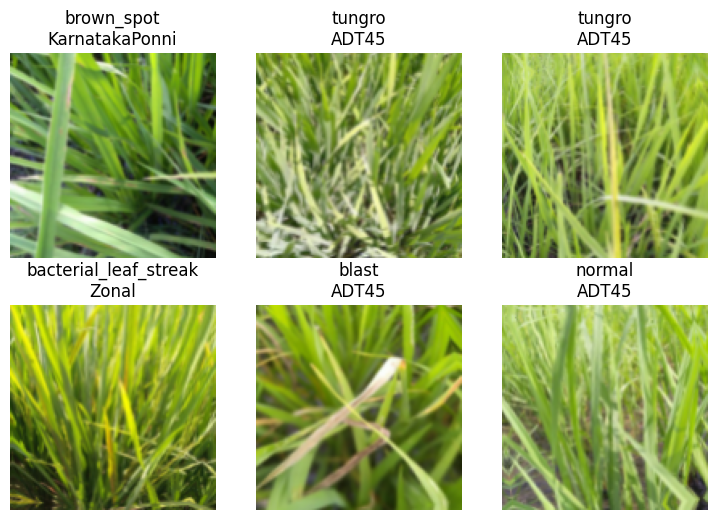

In [7]:
dls.show_batch(max_n=6)

Now, we can see that for each image, our dataloaders object stores two labels:
1. Disease
2. Variety

## Creating the Multi-target Model

When we use `vision_learner` with a single-target model, we don't actually have to pass a loss function. The API works it out for us.

But, now that we have a multi-target model the API can no longer do that, so we have to pass the loss function manually.

When we created our own neural networks (NNs), we used MSE and MAE as loss functions. But, these don't work for multi-class classification, only for binary classification. While we understand **why** we need to calculate loss, we also need to know **how** this is done.

So, we need to use a new technique called **cross-entropy loss**, which is something I touched on in the [manual NN for MNIST dataset](https://github.com/frank-895/machine_learning_journey/tree/main/manual_creation_of_NN). We've been unknowingly using cross-entropy loss every time we perform multi-class classification, as MAE and MSE only work for binary predictions.  

With neural networks, it's important to have a great understanding of the first layer and the last layer - and that includes the loss function. The middle layer is generally not so important, as it needs much less tinkering. As such, we're going to unpack this critical function to understand how it works.

The first function we need to understand is **softmax**, which takes our model's predictions (or **logits**) and turns it into **probabilities**.

| Label    | Output | Exp   | Softmax | Actuals | Index |
|----------|--------|-------|---------|---------|-------|
| cat      | -4.89  |  0.01 |   0.00  |    0    |   0   |
| dog      |  2.60  | 13.43 |   0.87  |    1    |   1   |
| plane    |  0.59  |  1.81 |   0.12  |    0    |   2   |
| fish     | -2.07  |  0.13 |   0.01  |    0    |   3   |
| building | -4.57  |  0.01 |   0.00  |    0    |   4   |
| **Sum**  |        | 15.38 |   1.00  |         |       |

Take the example above, where we are predicting which class an image belongs to. `Output` represents what the last layer of our model **actually** spits out, the **logit**.

We take the exponential of the predictions, and divide by the sum of the exponentials `15.38`, returning a probability array that sums to 1.

When we see how softmax works its easy to understand **why** a model will make a confident prediction even if it's passed an image which belongs to **none** of the classes. By taking the exponent, we are consistently exponentially increasing the confidence of our prediction on each epoch, essentially **forcing it to making a prediction.**

The formula for softmax is below.

$$
\sigma(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}
$$

Now that we understand softmax, we can understand cross-entropy loss.

| Label    | Softmax | Actuals | Cross-Entropy |
|----------|---------|---------|---------------|
| cat      |  0.00   |    0    |      0        |
| dog      |  0.87   |    1    |   -0.05892    |
| plane    |  0.12   |    0    |      0        |
| fish     |  0.01   |    0    |      0        |
| building |  0.00   |    0    |      0        |
| **Sum**  |         |         |    0.05892    |

We take our proabilities and we **one-hot encode** the actual label.

For each row, we take the actual value and multiply by the log of softmax. Then, we sum these values and make it negative.

In this situation, since only one class is true, **every row will be 0** except where $actual=1$.

So, our cross-entropy value for this instance will be
$$
-1*log(0.87) = -0.05892
$$

> Even though we could do this as a "matrix lookup" since only one $row != 0$, in math, it's better to have a consistent operation. It also depends on the situation - if you use cross-entropy loss where `actuals` does not have a single `1` value, the formula we are using will be necessary.

Then, the final step is to add the cross-entropy loss value of every row in the batch (i.e., every image in the batch) to calculate the final, **single** loss value.

Now that's all explained, the cross-entropy formula below should make a bit of sense!
$$
L = -\sum_{i=1}^{N} \sum_{j=1}^{C} y_{ij} \log (\hat{y}_{ij})
$$

We will use the PyTorch **function** `cross_entropy()` to do the above steps for **both** the disease prediction and the variety prediction.

All of the loss functions in PyTorch have 2 versions:
1. As a class
2. As a function

We can instantiate the class and it has more 'tweaks' or arguments. If we just want a standard cross-entropy loss, we can use the function which is stored in `torch.nn.functional`, pretty much always abbreviated to just `F`.

In [8]:
def disease_loss(inp, disease, variety):
  return F.cross_entropy(inp[:,:10], disease)

In [9]:
def variety_loss(inp, disease, variety):
  return F.cross_entropy(inp[:,10:], variety)

You'll note above that I use `inp[:,:10]` and `inp[:,10:]` as the model will be outputting a tensor of length **20** for each disease AND for each variety. The first 10 predictions will be used to predict disease and the last 10 will be used to predict variety.

We can combine the loss calculation for both predictions by summing them to find the **overall loss** for the batch.

In [10]:
def combine_loss(inp, disease, variety):
  return disease_loss(inp, disease, variety) + variety_loss(inp, disease, variety)

It would also be useful to see the error rate for both of the outputs, as well as the loss, which can combine all into a single function.

`error_rate` is a useful function from FastAI to calculate how accurate our model's predictions are.

In [11]:
def disease_err(inp,disease,variety):
  return error_rate(inp[:,:10],disease)

def variety_err(inp,disease,variety):
  return error_rate(inp[:,10:],variety)

err_metrics = (disease_err,variety_err)
all_metrics = err_metrics+(disease_loss,variety_loss)

Now, we can train our learner, using the `convnext` model we've previously found to be both fast and accurate!

We also need to define `n_out` which is the size of the last matrix. Since we are returning multiple targets, FastAI doesn't know how many outputs our model needs, so we pass `n_out=20` for our 10 diseases + our 10 varieties.

In [12]:
learn = vision_learner(dls,
                       'convnext_small_in22k',
                       loss_func=combine_loss,
                       metrics=all_metrics,
                       n_out=20
).to_fp16()

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

In [13]:
learn.fine_tune(5, 0.01)

epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,2.390054,1.412493,0.296012,0.137914,0.973127,0.439365,01:08


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,1.151906,0.705198,0.168669,0.061028,0.500691,0.204507,01:17
1,0.880867,0.462106,0.108121,0.034118,0.347790,0.114316,01:15
2,0.587996,0.246946,0.065834,0.020183,0.186980,0.059965,01:16
3,0.368198,0.201413,0.055742,0.009611,0.162186,0.039227,01:18
4,0.268481,0.172702,0.045171,0.008650,0.137472,0.035231,01:11


And the model is performing well, especially for predicting the variety, with an error rate of <1%. It is predicting the disease at over 95% accuracy too.

## Conclusion

This notebook has been very useful for understanding cross-entropy loss which is critical for multi-class and multi-target classification.

**Is multi-target classification useful in practice?**

Well... it depends. If you need to predict multiple things about an input, then yes! It can certainly be useful as it can pick up on interdependencies between the different labels and improve computational efficiency.

But, even if you only need to predict a single target, if the targets you predict in a multi-target model are correlated or share underlying patterns, you can possibly improve your predictions on the single target.

For example, in this competition, it's possible that the diseases 'look different' to the model depending on which variety of rice **has the disease**. So, by predicting both things, we can improve our disease prediction.

Thus, **multi-target classification is certainly useful in many contexts**, and it is a good way to understand the lower-levels of FastAI and loss functions.

Thanks for reading my notebook, and thanks again to [FastAI](https://www.fast.ai/) for the material!